#**Описание проекта**
Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.

Постройте модель с предельно большим значением F1-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте F1-меру на тестовой выборке самостоятельно.


Дополнительно измеряйте AUC-ROC, сравнивайте её значение с F1-мерой.


##**Инструкция по выполнению проекта**


1. Загрузите и подготовьте данные. Поясните порядок действий.
2. Исследуйте баланс классов, обучите модель без учёта дисбаланса. Кратко опишите выводы.
3. Улучшите качество модели, учитывая дисбаланс классов. Обучите разные модели и найдите лучшую. Кратко опишите выводы.
4. Проведите финальное тестирование.

##**Описание данных**

Данные находятся в файле /datasets/Churn.csv (англ. «отток клиентов»). Скачать датасет

##**Признаки**

 - `RowNumber` — индекс строки в данных
 - `CustomerId` — уникальный идентификатор клиента
 - `Surname` — фамилия
 - `CreditScore` — кредитный рейтинг
 - `Geography` — страна проживания
 - `Gender` — пол
 - `Age` — возраст
 - `Tenure` — сколько лет человек является клиентом банка
 - `Balance` — баланс на счёте
 - `NumOfProducts` — количество продуктов банка, используемых клиентом
 - `HasCrCard` — наличие кредитной карты
 - `IsActiveMember` — активность клиента
 - `EstimatedSalary` — предполагаемая зарплата

##**Целевой признак**
 - `Exited` — факт ухода клиента

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, precision_recall_curve
from sklearn.impute import KNNImputer
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import random

##**1. Загрузите и подготовьте данные. Поясните порядок действий.**

In [ ]:
url = 'https://drive.google.com/file/d/1Y0HxN-VQpm0pAgXkEUq8DFhpY2vDMa6z/view?usp=drive_link'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
df = pd.read_csv(path)
data = df.copy()
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [ ]:
df.duplicated().sum()

0

In [ ]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [ ]:
df.loc[df['Tenure'].isna()]

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
30,31,15589475,Azikiwe,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,49,15766205,Yin,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,52,15768193,Trevisani,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,54,15702298,Parkhill,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,61,15651280,Hunter,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9944,9945,15703923,Cameron,744,Germany,Male,41,NaN,190409.34,2,1,1,138361.48,0
9956,9957,15707861,Nucci,520,France,Female,46,NaN,85216.61,1,1,0,117369.52,1
9964,9965,15642785,Douglas,479,France,Male,34,NaN,117593.48,2,0,0,113308.29,0
9985,9986,15586914,Nepean,659,France,Male,36,NaN,123841.49,2,1,0,96833.00,0


In [ ]:
df['Geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [ ]:
df['Gender'].unique()

array(['Female', 'Male'], dtype=object)

###**План действий по подготовке данных**
**Для моделей решающего дерева и случайного леса**
 - признаки `RowNUmber`(индекс строки в данных), `CustomerId`(уникальный идентификатор клиента), `Surname`(фамилия клиента) - не содержат никакой полезной информации с точки зрения машинного обучения, поэтому их нужно будет удалить.
 - категориальных строковых признака всего два:
  - `Geography`(страна проживания) содержит всего три уникальных значения
  - `Gender` (пол) содержит два уникальных значения
  поэтому можно обработать эти признаки методом OHE(One Hot Encoding), так как это не создаст слишком много дополнительных столбцов после кодидировки.
 - разделение данных на обучающую, валидационную и тестовые выборки в пропорции  60:20:20 для моделей решающего дерева и случайного леса (так эти модели могут работать с пропущенными значениями и для них не надо нормализовать числовые признаки);

**Для логистической регрессии потребуются дополнительные шаги в подготовке данных:**

 - переменная `Tenure` содержит 909 незаполненных значение `NaN` это 9% от всего объема данных, что довольно много. Нужно будет заполнить пропущенные значения

 - нормализация(масштабирование) числовых признкаков:
    - `CreditScore`(кредитный рейтинг)
    - `Age`(возраст)
    - `Tenure`(сколько лет человек является клиентом банка)
    - `Balance`(баланкс на счете)
    - `NumOfProducts`(количество продуктов банка, используемых клиентом)
    - `EstimatedSalary`(предпологаемая зарплата)  

In [ ]:
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

In [ ]:
df_ohe = pd.get_dummies(df, drop_first = True)
df_ohe.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,False,False,False
1,608,41,1.0,83807.86,1,0,1,112542.58,0,False,True,False
2,502,42,8.0,159660.80,3,1,0,113931.57,1,False,False,False
3,699,39,1.0,0.00,2,0,0,93826.63,0,False,False,False
4,850,43,2.0,125510.82,1,1,1,79084.10,0,False,True,False


In [ ]:
features = df_ohe.drop('Exited', axis=1)
target = df_ohe['Exited']

In [ ]:
features_train_tr, features_valid_tr, target_train, target_valid = train_test_split(
                       features, target, test_size=0.4, stratify=target, random_state=12345)

features_valid_tr, features_test_tr, target_valid, target_test = train_test_split(
                      features_valid_tr, target_valid, test_size=0.5, stratify=target_valid, random_state=12345)

print(f'''Размер изначального датасета - {df_ohe.shape}
Размер features_train_tr - {features_train_tr.shape}   Размер target_train  - {target_train.shape}
Размер features_valid_tr - {features_valid_tr.shape}   Размер target_valid  - {target_valid.shape}
Размер features_test_tr -  {features_test_tr.shape}   Размер target_test  -  {target_test.shape}      ''')

Размер изначального датасета - (10000, 12)
Размер features_train_tr - (6000, 11)   Размер target_train  - (6000,)
Размер features_valid_tr - (2000, 11)   Размер target_valid  - (2000,)
Размер features_test_tr -  (2000, 11)   Размер target_test  -  (2000,)      


In [ ]:
list_nan_index = df_ohe.loc[df['Tenure'].isna()].index.to_list()
len(list_nan_index)

909

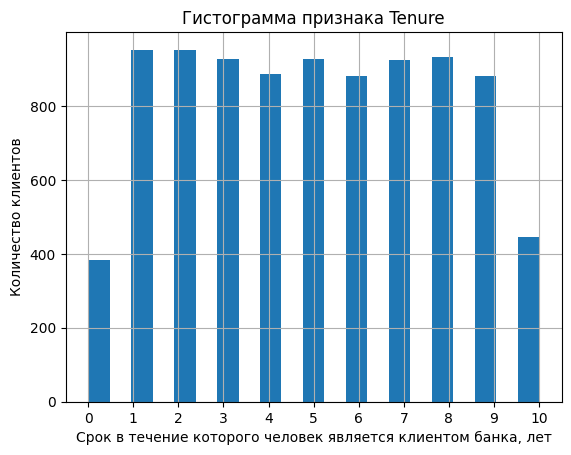

In [ ]:
df_ohe.hist('Tenure', bins=21)
plt.xlabel('Срок в течение которого человек является клиентом банка, лет')
plt.ylabel('Количество клиентов')
plt.xticks(range(11))
plt.title('Гистограмма признака Tenure')
plt.show()

Заполним пропущенные значения в `Tenure` таким образом, чтобы после заполнения форма гистограммы осталась прежней. Для этого создадим словарь, в котором ключом будет являться количество лет, которое человек является клиентом, а значением количество раз, которое эта значение нужно будет вставить. То есть, 0 лет нужно будет вставить 38 раз в датасет, 1 год нужно будет вставить 95 раз в датасет, 2 года нужно будет вставить 95 раз и так далее. Создадим список индексов с незаполненными значениями и далее будем случайным образом выбирать индекс из этого списка заполнять пропущенное значение согласно словарю и далее удалять этот индекс из списка до тех пор пока список не будет пуст.

In [ ]:
d = (df_ohe['Tenure'].value_counts(normalize=True)*909).sort_index().round().to_dict()
d # вначале считаем количесто пропущенных значений по каждому году в процентном
  # соотношении. Далее умножив на общее количество 909 и округлив получим, количество
  # пропущенных значений по каждому году.

{0.0: 38.0,
 1.0: 95.0,
 2.0: 95.0,
 3.0: 93.0,
 4.0: 88.0,
 5.0: 93.0,
 6.0: 88.0,
 7.0: 92.0,
 8.0: 93.0,
 9.0: 88.0,
 10.0: 45.0}

In [ ]:
sum(list(d.values())) # выполним проверку суммы после округления

908.0

In [ ]:
d[0.0] = d[0.0] + 1 # получили 908 вместо 909, поэтому прибавляем один в значение ключа 0 лет

In [ ]:
d

{0.0: 39.0,
 1.0: 95.0,
 2.0: 95.0,
 3.0: 93.0,
 4.0: 88.0,
 5.0: 93.0,
 6.0: 88.0,
 7.0: 92.0,
 8.0: 93.0,
 9.0: 88.0,
 10.0: 45.0}

In [ ]:
sum(list(d.values())) # сумма пропущенных значений стала 909, можно приступать к заполению

909.0

In [ ]:
for key, value in d.items():
  for i in range(int(value)):
    random.seed(10)
    ind = random.choice(list_nan_index)
    df_ohe.loc[ind,'Tenure'] = key
    list_nan_index.remove(ind)

In [ ]:
df_ohe.isna().sum()   # пропущенных значений нет

,0
CreditScore,0
Age,0
Tenure,0
Balance,0
NumOfProducts,0
HasCrCard,0
IsActiveMember,0
EstimatedSalary,0
Exited,0
Geography_Germany,0


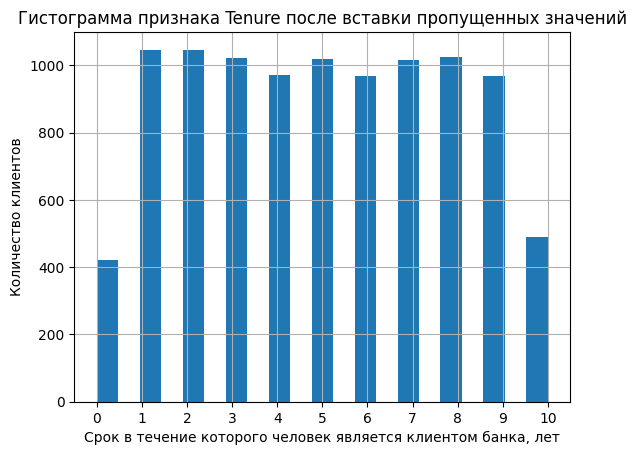

In [ ]:
df_ohe.hist('Tenure', bins=21)
plt.xlabel('Срок в течение которого человек является клиентом банка, лет')
plt.ylabel('Количество клиентов')
plt.xticks(range(11))
plt.title('Гистограмма признака Tenure после вставки пропущенных значений')
plt.show()

In [ ]:
features = df_ohe.drop('Exited', axis=1)
target = df_ohe['Exited']
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [ ]:
features_train_lr, features_valid_lr, target_train, target_valid = train_test_split(
                       features, target, test_size=0.4, stratify=target, random_state=12345)

features_valid_lr, features_test_lr, target_valid, target_test = train_test_split(
                      features_valid_lr, target_valid, test_size=0.5, stratify=target_valid, random_state=12345)

print(f'''Размер изначального датасета - {df_ohe.shape}
Размер features_train_lr - {features_train_lr.shape}   Размер target_train  - {target_train.shape}
Размер features_valid_lr - {features_valid_lr.shape}   Размер target_valid  - {target_valid.shape}
Размер features_test_lr -  {features_test_lr.shape}   Размер target_test  -  {target_test.shape}      ''')

Размер изначального датасета - (10000, 12)
Размер features_train_lr - (6000, 11)   Размер target_train  - (6000,)
Размер features_valid_lr - (2000, 11)   Размер target_valid  - (2000,)
Размер features_test_lr -  (2000, 11)   Размер target_test  -  (2000,)      


In [ ]:
scaler = StandardScaler()
scaler.fit(features_train_lr[numeric])
features_train_lr[numeric] = scaler.transform(features_train_lr[numeric])
features_valid_lr[numeric] = scaler.transform(features_valid_lr[numeric])
features_test_lr[numeric] = scaler.transform(features_test_lr[numeric])


В итоге получили два набора данных для обучения решающего дерева и случайного леса:
 - features_train_tr, features_valid_tr, features_test_tr ( здесь были только закодированы категориальные признаки с помощью OHE)
И для логистической регрессии:
 - features_train_lr, features_valid_lr, features_test_lr ( дополнительно были вставлены пропущенные значения и выполнено масштабирование числовых признаков)

##**2. Исследуйте баланс классов, обучите модель без учёта дисбаланса. Кратко опишите выводы.**

In [ ]:
balance = target_train.value_counts(normalize=True)
balance

,proportion
Exited,
0,0.796333
1,0.203667


In [ ]:
balance[0]/balance[1]

3.909983633387889

В наборе данных дисбаланс. Объекотов с целевым признаком `0` приблизительно в четыре раза больше, чем объектов с целевым признаком `1`. Это будет плохо сказываться на обучении моделей.

In [ ]:
model = LogisticRegression(solver='liblinear', random_state=12345)
model.fit(features_train_lr, target_train)
predicted_valid = model.predict(features_valid_lr)
f1 = f1_score(target_valid, predicted_valid)
auc_roc = roc_auc_score(target_valid, predicted_valid)
print(f'f1 = {f1:.4f}, auc-roc = {auc_roc:.4f}')

f1 = 0.3133, auc-roc = 0.5881


In [ ]:
for depth in range(1,21):
  model = DecisionTreeClassifier(max_depth = depth, random_state=12345)
  model.fit(features_train_tr, target_train)
  predicted_valid = model.predict(features_valid_tr)
  predicted_train = model.predict(features_train_tr)
  f1_train = f1_score(target_train, predicted_train)
  f1_valid = f1_score(target_valid, predicted_valid)
  auc_roc_valid = roc_auc_score(target_valid, predicted_valid)
  print(f'max_depth = {depth:>2}, f1_train = {f1_train:.4f}, f1_valid = {f1_valid:.4f}, auc-roc_valid = {auc_roc_valid:.4f}')

max_depth =  1, f1_train = 0.0000, f1_valid = 0.0000, auc-roc_valid = 0.5000
max_depth =  2, f1_train = 0.5152, f1_valid = 0.5203, auc-roc_valid = 0.6876
max_depth =  3, f1_train = 0.5272, f1_valid = 0.5376, auc-roc_valid = 0.6972
max_depth =  4, f1_train = 0.5271, f1_valid = 0.5206, auc-roc_valid = 0.6828
max_depth =  5, f1_train = 0.5439, f1_valid = 0.5455, auc-roc_valid = 0.6945
max_depth =  6, f1_train = 0.5804, f1_valid = 0.5745, auc-roc_valid = 0.7125
max_depth =  7, f1_train = 0.6112, f1_valid = 0.5965, auc-roc_valid = 0.7289
max_depth =  8, f1_train = 0.6162, f1_valid = 0.5566, auc-roc_valid = 0.7029
max_depth =  9, f1_train = 0.6820, f1_valid = 0.5645, auc-roc_valid = 0.7122
max_depth = 10, f1_train = 0.7319, f1_valid = 0.5513, auc-roc_valid = 0.7066
max_depth = 11, f1_train = 0.7738, f1_valid = 0.5494, auc-roc_valid = 0.7086
max_depth = 12, f1_train = 0.8168, f1_valid = 0.5239, auc-roc_valid = 0.6953
max_depth = 13, f1_train = 0.8707, f1_valid = 0.5284, auc-roc_valid = 0.7015

In [ ]:
for depth in range(1,21):
  model = RandomForestClassifier(n_estimators=20, max_depth = depth, random_state=12345)
  model.fit(features_train_tr, target_train)
  predicted_valid = model.predict(features_valid_tr)
  predicted_train = model.predict(features_train_tr)
  f1_train = f1_score(target_train, predicted_train)
  f1_valid = f1_score(target_valid, predicted_valid)
  auc_roc_valid = roc_auc_score(target_valid, predicted_valid)
  print(f'max_depth = {depth:>2}, f1_train = {f1_train:.4f}, f1_valid = {f1_valid:.4f}, auc-roc_valid = {auc_roc_valid:.4f}')

max_depth =  1, f1_train = 0.0000, f1_valid = 0.0000, auc-roc_valid = 0.5000
max_depth =  2, f1_train = 0.1386, f1_valid = 0.1700, auc-roc_valid = 0.5463
max_depth =  3, f1_train = 0.2080, f1_valid = 0.2542, auc-roc_valid = 0.5723
max_depth =  4, f1_train = 0.4906, f1_valid = 0.5068, auc-roc_valid = 0.6726
max_depth =  5, f1_train = 0.5459, f1_valid = 0.5624, auc-roc_valid = 0.7034
max_depth =  6, f1_train = 0.5554, f1_valid = 0.5422, auc-roc_valid = 0.6918
max_depth =  7, f1_train = 0.5843, f1_valid = 0.5705, auc-roc_valid = 0.7088
max_depth =  8, f1_train = 0.6192, f1_valid = 0.5833, auc-roc_valid = 0.7156
max_depth =  9, f1_train = 0.6533, f1_valid = 0.6037, auc-roc_valid = 0.7269
max_depth = 10, f1_train = 0.6879, f1_valid = 0.5841, auc-roc_valid = 0.7168
max_depth = 11, f1_train = 0.7480, f1_valid = 0.6030, auc-roc_valid = 0.7272
max_depth = 12, f1_train = 0.8033, f1_valid = 0.5982, auc-roc_valid = 0.7251
max_depth = 13, f1_train = 0.8508, f1_valid = 0.5938, auc-roc_valid = 0.7250

In [ ]:
for est in range(1,300,10):
  model = RandomForestClassifier(n_estimators=est, max_depth = 6, random_state=12345)
  model.fit(features_train_tr, target_train)
  predicted_valid = model.predict(features_valid_tr)
  predicted_train = model.predict(features_train_tr)
  f1_train = f1_score(target_train, predicted_train)
  f1_valid = f1_score(target_valid, predicted_valid)
  auc_roc_valid = roc_auc_score(target_valid, predicted_valid)
  print(f'n_estimators = {est:>3}, f1_train = {f1_train:.4f}, f1_valid = {f1_valid:.4f}, auc-roc_valid = {auc_roc_valid:.4f}')

n_estimators =   1, f1_train = 0.3752, f1_valid = 0.4058, auc-roc_valid = 0.6272
n_estimators =  11, f1_train = 0.5526, f1_valid = 0.5466, auc-roc_valid = 0.6945
n_estimators =  21, f1_train = 0.5567, f1_valid = 0.5405, auc-roc_valid = 0.6912
n_estimators =  31, f1_train = 0.5592, f1_valid = 0.5411, auc-roc_valid = 0.6917
n_estimators =  41, f1_train = 0.5554, f1_valid = 0.5383, auc-roc_valid = 0.6896
n_estimators =  51, f1_train = 0.5549, f1_valid = 0.5375, auc-roc_valid = 0.6893
n_estimators =  61, f1_train = 0.5584, f1_valid = 0.5377, auc-roc_valid = 0.6890
n_estimators =  71, f1_train = 0.5605, f1_valid = 0.5368, auc-roc_valid = 0.6887
n_estimators =  81, f1_train = 0.5530, f1_valid = 0.5329, auc-roc_valid = 0.6866
n_estimators =  91, f1_train = 0.5514, f1_valid = 0.5377, auc-roc_valid = 0.6890
n_estimators = 101, f1_train = 0.5527, f1_valid = 0.5437, auc-roc_valid = 0.6927
n_estimators = 111, f1_train = 0.5502, f1_valid = 0.5455, auc-roc_valid = 0.6933
n_estimators = 121, f1_train

Без учета дисбаланска получили следующие результаты:
 - логистическая регрессия f1 = 0.3133, roc-auc = 0.5881
 - решающее дерево         f1 = 0.5745, roc-auc = 0.7125 (max_depth=6)
 - случайный лес           f1 = 0.5444, roc-auc = 0.6933 (max_depth=6, n_estimators = 111)
 Лучший результат без учета дисбаланса получился у решающего дерева.

##**3. Улучшите качество модели, учитывая дисбаланс классов. Обучите разные модели и найдите лучшую. Кратко опишите вывод**

Так как у нас имеется дисбаланс классов ( объектов с целевым признаком `0` приблизительно в черыре раза больше, чем объектов с целевым признаком `1`) попробуем увеличить метрики моделей применяя параметр `class_weight=balanced`, методику `upsample` а так же их комбинацию (`class_weight=balanced` и `upsample`)

Функция `upsample` будет устранять дисбаланс классов.

In [ ]:
def upsample(features, target, repeat):
  features_zeros = features[target==0]
  features_ones = features[target==1]
  target_zeros = target[target==0]
  target_ones = target[target==1]
  features_upsampled = pd.concat([features_zeros] + [features_ones]*repeat)
  target_upsampled = pd.concat([target_zeros] + [target_ones]*repeat)
  features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled,
                                                 random_state=12345)
  return features_upsampled, target_upsampled


In [ ]:
features_upsampled_lr, target_upsampled_lr = upsample(features_train_lr, target_train,4)

###**Логистическая регрессия**

In [ ]:
model = LogisticRegression(solver='liblinear', random_state=12345, class_weight='balanced')
model.fit(features_train_lr, target_train)
predicted_valid = model.predict(features_valid_lr)
f1 = f1_score(target_valid, predicted_valid)
auc_roc = roc_auc_score(target_valid, predicted_valid)
print(f'f1 = {f1:.4f}, auc-roc = {auc_roc:.4f}')

f1 = 0.5290, auc-roc = 0.7341


In [ ]:
model = LogisticRegression(solver='liblinear', random_state=12345)
model.fit(features_upsampled_lr, target_upsampled_lr)
predicted_valid = model.predict(features_valid_lr)
f1 = f1_score(target_valid, predicted_valid)
auc_roc = roc_auc_score(target_valid, predicted_valid)
print(f'f1 = {f1:.4f}, auc-roc = {auc_roc:.4f}')

f1 = 0.5260, auc-roc = 0.7328


In [ ]:
model = LogisticRegression(solver='liblinear', random_state=12345, class_weight='balanced')
model.fit(features_upsampled_lr, target_upsampled_lr)
predicted_valid = model.predict(features_valid_lr)
f1 = f1_score(target_valid, predicted_valid)
auc_roc = roc_auc_score(target_valid, predicted_valid)
print(f'f1 = {f1:.4f}, auc-roc = {auc_roc:.4f}')

f1 = 0.5290, auc-roc = 0.7341


###**Решающее дерево**

In [ ]:
for depth in range(1,21):
  model = DecisionTreeClassifier(max_depth = depth, random_state=12345, class_weight='balanced')
  model.fit(features_train_tr, target_train)
  predicted_valid = model.predict(features_valid_tr)
  predicted_train = model.predict(features_train_tr)
  f1_train = f1_score(target_train, predicted_train)
  f1_valid = f1_score(target_valid, predicted_valid)
  auc_roc_valid = roc_auc_score(target_valid, predicted_valid)
  print(f'max_depth = {depth:>2}, f1_train = {f1_train:.4f}, f1_valid = {f1_valid:.4f}, auc-roc_valid = {auc_roc_valid:.4f}')

max_depth =  1, f1_train = 0.4735, f1_valid = 0.4847, auc-roc_valid = 0.7012
max_depth =  2, f1_train = 0.4907, f1_valid = 0.4980, auc-roc_valid = 0.7152
max_depth =  3, f1_train = 0.5339, f1_valid = 0.5207, auc-roc_valid = 0.7015
max_depth =  4, f1_train = 0.5505, f1_valid = 0.5609, auc-roc_valid = 0.7595
max_depth =  5, f1_train = 0.5569, f1_valid = 0.5546, auc-roc_valid = 0.7665
max_depth =  6, f1_train = 0.6023, f1_valid = 0.5759, auc-roc_valid = 0.7677
max_depth =  7, f1_train = 0.6176, f1_valid = 0.5719, auc-roc_valid = 0.7676
max_depth =  8, f1_train = 0.6327, f1_valid = 0.5479, auc-roc_valid = 0.7473
max_depth =  9, f1_train = 0.6772, f1_valid = 0.5397, auc-roc_valid = 0.7329
max_depth = 10, f1_train = 0.7142, f1_valid = 0.5271, auc-roc_valid = 0.7211
max_depth = 11, f1_train = 0.7663, f1_valid = 0.5272, auc-roc_valid = 0.7159
max_depth = 12, f1_train = 0.7993, f1_valid = 0.5189, auc-roc_valid = 0.7094
max_depth = 13, f1_train = 0.8323, f1_valid = 0.5352, auc-roc_valid = 0.7185

In [ ]:
features_upsampled_tr, target_upsampled_tr = upsample(features_train_tr, target_train,4)

In [ ]:
for depth in range(1,21):
  model = DecisionTreeClassifier(max_depth = depth, random_state=12345)
  model.fit(features_upsampled_tr, target_upsampled_tr)
  predicted_valid = model.predict(features_valid_tr)
  predicted_train = model.predict(features_train_tr)
  f1_train = f1_score(target_train, predicted_train)
  f1_valid = f1_score(target_valid, predicted_valid)
  auc_roc_valid = roc_auc_score(target_valid, predicted_valid)
  print(f'max_depth = {depth:>2}, f1_train = {f1_train:.4f}, f1_valid = {f1_valid:.4f}, auc-roc_valid = {auc_roc_valid:.4f}')

max_depth =  1, f1_train = 0.4735, f1_valid = 0.4847, auc-roc_valid = 0.7012
max_depth =  2, f1_train = 0.4907, f1_valid = 0.4980, auc-roc_valid = 0.7152
max_depth =  3, f1_train = 0.4907, f1_valid = 0.4980, auc-roc_valid = 0.7152
max_depth =  4, f1_train = 0.5505, f1_valid = 0.5609, auc-roc_valid = 0.7595
max_depth =  5, f1_train = 0.5569, f1_valid = 0.5546, auc-roc_valid = 0.7665
max_depth =  6, f1_train = 0.6023, f1_valid = 0.5759, auc-roc_valid = 0.7677
max_depth =  7, f1_train = 0.6176, f1_valid = 0.5725, auc-roc_valid = 0.7679
max_depth =  8, f1_train = 0.6333, f1_valid = 0.5477, auc-roc_valid = 0.7475
max_depth =  9, f1_train = 0.6792, f1_valid = 0.5389, auc-roc_valid = 0.7317
max_depth = 10, f1_train = 0.7145, f1_valid = 0.5335, auc-roc_valid = 0.7248
max_depth = 11, f1_train = 0.7626, f1_valid = 0.5225, auc-roc_valid = 0.7142
max_depth = 12, f1_train = 0.8000, f1_valid = 0.5260, auc-roc_valid = 0.7138
max_depth = 13, f1_train = 0.8303, f1_valid = 0.5356, auc-roc_valid = 0.7191

In [ ]:
for depth in range(1,21):
  model = DecisionTreeClassifier(max_depth = depth, random_state=12345, class_weight='balanced')
  model.fit(features_upsampled_tr, target_upsampled_tr)
  predicted_valid = model.predict(features_valid_tr)
  predicted_train = model.predict(features_train_tr)
  f1_train = f1_score(target_train, predicted_train)
  f1_valid = f1_score(target_valid, predicted_valid)
  auc_roc_valid = roc_auc_score(target_valid, predicted_valid)
  print(f'max_depth = {depth:>2}, f1_train = {f1_train:.4f}, f1_valid = {f1_valid:.4f}, auc-roc_valid = {auc_roc_valid:.4f}')

max_depth =  1, f1_train = 0.4735, f1_valid = 0.4847, auc-roc_valid = 0.7012
max_depth =  2, f1_train = 0.4907, f1_valid = 0.4980, auc-roc_valid = 0.7152
max_depth =  3, f1_train = 0.5339, f1_valid = 0.5207, auc-roc_valid = 0.7015
max_depth =  4, f1_train = 0.5505, f1_valid = 0.5609, auc-roc_valid = 0.7595
max_depth =  5, f1_train = 0.5569, f1_valid = 0.5546, auc-roc_valid = 0.7665
max_depth =  6, f1_train = 0.6023, f1_valid = 0.5759, auc-roc_valid = 0.7677
max_depth =  7, f1_train = 0.6176, f1_valid = 0.5725, auc-roc_valid = 0.7679
max_depth =  8, f1_train = 0.6333, f1_valid = 0.5482, auc-roc_valid = 0.7479
max_depth =  9, f1_train = 0.6772, f1_valid = 0.5411, auc-roc_valid = 0.7342
max_depth = 10, f1_train = 0.7141, f1_valid = 0.5287, auc-roc_valid = 0.7220
max_depth = 11, f1_train = 0.7667, f1_valid = 0.5240, auc-roc_valid = 0.7137
max_depth = 12, f1_train = 0.8001, f1_valid = 0.5111, auc-roc_valid = 0.7030
max_depth = 13, f1_train = 0.8317, f1_valid = 0.5277, auc-roc_valid = 0.7130

###**Случайный лес**

In [ ]:
for depth in range(1,21):
  model = RandomForestClassifier(n_estimators=20, max_depth = depth, random_state=12345, class_weight='balanced')
  model.fit(features_train_tr, target_train)
  predicted_valid = model.predict(features_valid_tr)
  predicted_train = model.predict(features_train_tr)
  f1_train = f1_score(target_train, predicted_train)
  f1_valid = f1_score(target_valid, predicted_valid)
  auc_roc_valid = roc_auc_score(target_valid, predicted_valid)
  print(f'max_depth = {depth:>2}, f1_train = {f1_train:.4f}, f1_valid = {f1_valid:.4f}, auc-roc_valid = {auc_roc_valid:.4f}')

max_depth =  1, f1_train = 0.5390, f1_valid = 0.5444, auc-roc_valid = 0.7416
max_depth =  2, f1_train = 0.5637, f1_valid = 0.5706, auc-roc_valid = 0.7593
max_depth =  3, f1_train = 0.5608, f1_valid = 0.5826, auc-roc_valid = 0.7754
max_depth =  4, f1_train = 0.5906, f1_valid = 0.6050, auc-roc_valid = 0.7790
max_depth =  5, f1_train = 0.6065, f1_valid = 0.6179, auc-roc_valid = 0.7871
max_depth =  6, f1_train = 0.6356, f1_valid = 0.6056, auc-roc_valid = 0.7743
max_depth =  7, f1_train = 0.6659, f1_valid = 0.6291, auc-roc_valid = 0.7883
max_depth =  8, f1_train = 0.7111, f1_valid = 0.6324, auc-roc_valid = 0.7827
max_depth =  9, f1_train = 0.7387, f1_valid = 0.6303, auc-roc_valid = 0.7785
max_depth = 10, f1_train = 0.8115, f1_valid = 0.6423, auc-roc_valid = 0.7809
max_depth = 11, f1_train = 0.8555, f1_valid = 0.6287, auc-roc_valid = 0.7654
max_depth = 12, f1_train = 0.8996, f1_valid = 0.6152, auc-roc_valid = 0.7479
max_depth = 13, f1_train = 0.9300, f1_valid = 0.6104, auc-roc_valid = 0.7425

In [ ]:
for est in range(1,300,10):
  model = RandomForestClassifier(n_estimators=est, max_depth = 4, random_state=12345, class_weight='balanced')
  model.fit(features_train_tr, target_train)
  predicted_valid = model.predict(features_valid_tr)
  predicted_train = model.predict(features_train_tr)
  f1_train = f1_score(target_train, predicted_train)
  f1_valid = f1_score(target_valid, predicted_valid)
  auc_roc_valid = roc_auc_score(target_valid, predicted_valid)
  print(f'n_estimators = {est:>3}, f1_train = {f1_train:.4f}, f1_valid = {f1_valid:.4f}, auc-roc_valid = {auc_roc_valid:.4f}')

n_estimators =   1, f1_train = 0.5659, f1_valid = 0.5958, auc-roc_valid = 0.7519
n_estimators =  11, f1_train = 0.5881, f1_valid = 0.6152, auc-roc_valid = 0.7873
n_estimators =  21, f1_train = 0.5875, f1_valid = 0.6083, auc-roc_valid = 0.7833
n_estimators =  31, f1_train = 0.5902, f1_valid = 0.6033, auc-roc_valid = 0.7817
n_estimators =  41, f1_train = 0.5883, f1_valid = 0.6127, auc-roc_valid = 0.7896
n_estimators =  51, f1_train = 0.5893, f1_valid = 0.6091, auc-roc_valid = 0.7878
n_estimators =  61, f1_train = 0.5854, f1_valid = 0.6086, auc-roc_valid = 0.7895
n_estimators =  71, f1_train = 0.5875, f1_valid = 0.6078, auc-roc_valid = 0.7901
n_estimators =  81, f1_train = 0.5869, f1_valid = 0.6136, auc-roc_valid = 0.7932
n_estimators =  91, f1_train = 0.5863, f1_valid = 0.6086, auc-roc_valid = 0.7895
n_estimators = 101, f1_train = 0.5874, f1_valid = 0.6072, auc-roc_valid = 0.7898
n_estimators = 111, f1_train = 0.5872, f1_valid = 0.6061, auc-roc_valid = 0.7877
n_estimators = 121, f1_train

In [ ]:
for depth in range(1,21):
  model = RandomForestClassifier(n_estimators=20, max_depth = depth, random_state=12345)
  model.fit(features_upsampled_tr, target_upsampled_tr)
  predicted_valid = model.predict(features_valid_tr)
  predicted_train = model.predict(features_train_tr)
  f1_train = f1_score(target_train, predicted_train)
  f1_valid = f1_score(target_valid, predicted_valid)
  auc_roc_valid = roc_auc_score(target_valid, predicted_valid)
  print(f'max_depth = {depth:>2}, f1_train = {f1_train:.4f}, f1_valid = {f1_valid:.4f}, auc-roc_valid = {auc_roc_valid:.4f}')

max_depth =  1, f1_train = 0.5309, f1_valid = 0.5383, auc-roc_valid = 0.7421
max_depth =  2, f1_train = 0.5420, f1_valid = 0.5551, auc-roc_valid = 0.7546
max_depth =  3, f1_train = 0.5603, f1_valid = 0.5857, auc-roc_valid = 0.7790
max_depth =  4, f1_train = 0.5858, f1_valid = 0.6062, auc-roc_valid = 0.7847
max_depth =  5, f1_train = 0.6018, f1_valid = 0.6072, auc-roc_valid = 0.7898
max_depth =  6, f1_train = 0.6268, f1_valid = 0.6195, auc-roc_valid = 0.7937
max_depth =  7, f1_train = 0.6565, f1_valid = 0.6279, auc-roc_valid = 0.7969
max_depth =  8, f1_train = 0.7174, f1_valid = 0.6327, auc-roc_valid = 0.7943
max_depth =  9, f1_train = 0.7526, f1_valid = 0.6250, auc-roc_valid = 0.7858
max_depth = 10, f1_train = 0.8178, f1_valid = 0.6275, auc-roc_valid = 0.7805
max_depth = 11, f1_train = 0.8599, f1_valid = 0.6271, auc-roc_valid = 0.7788
max_depth = 12, f1_train = 0.9216, f1_valid = 0.6356, auc-roc_valid = 0.7748
max_depth = 13, f1_train = 0.9549, f1_valid = 0.6083, auc-roc_valid = 0.7549

In [ ]:
for est in range(1,300,10):
  model = RandomForestClassifier(n_estimators=est, max_depth = 5, random_state=12345)
  model.fit(features_upsampled_tr, target_upsampled_tr)
  predicted_valid = model.predict(features_valid_tr)
  predicted_train = model.predict(features_train_tr)
  f1_train = f1_score(target_train, predicted_train)
  f1_valid = f1_score(target_valid, predicted_valid)
  auc_roc_valid = roc_auc_score(target_valid, predicted_valid)
  print(f'n_estimators = {est:>3}, f1_train = {f1_train:.4f}, f1_valid = {f1_valid:.4f}, auc-roc_valid = {auc_roc_valid:.4f}')

n_estimators =   1, f1_train = 0.5197, f1_valid = 0.5420, auc-roc_valid = 0.7435
n_estimators =  11, f1_train = 0.5975, f1_valid = 0.6032, auc-roc_valid = 0.7890
n_estimators =  21, f1_train = 0.6004, f1_valid = 0.6088, auc-roc_valid = 0.7901
n_estimators =  31, f1_train = 0.6011, f1_valid = 0.6158, auc-roc_valid = 0.7939
n_estimators =  41, f1_train = 0.5986, f1_valid = 0.6132, auc-roc_valid = 0.7935
n_estimators =  51, f1_train = 0.6020, f1_valid = 0.6172, auc-roc_valid = 0.7951
n_estimators =  61, f1_train = 0.6014, f1_valid = 0.6158, auc-roc_valid = 0.7939
n_estimators =  71, f1_train = 0.6021, f1_valid = 0.6120, auc-roc_valid = 0.7929
n_estimators =  81, f1_train = 0.6012, f1_valid = 0.6130, auc-roc_valid = 0.7929
n_estimators =  91, f1_train = 0.6026, f1_valid = 0.6126, auc-roc_valid = 0.7932
n_estimators = 101, f1_train = 0.6032, f1_valid = 0.6163, auc-roc_valid = 0.7957
n_estimators = 111, f1_train = 0.6006, f1_valid = 0.6144, auc-roc_valid = 0.7941
n_estimators = 121, f1_train

In [ ]:
for depth in range(1,21):
  model = RandomForestClassifier(n_estimators=20, max_depth = depth, random_state=12345, class_weight='balanced')
  model.fit(features_upsampled_tr, target_upsampled_tr)
  predicted_valid = model.predict(features_valid_tr)
  predicted_train = model.predict(features_train_tr)
  f1_train = f1_score(target_train, predicted_train)
  f1_valid = f1_score(target_valid, predicted_valid)
  auc_roc_valid = roc_auc_score(target_valid, predicted_valid)
  print(f'max_depth = {depth:>2}, f1_train = {f1_train:.4f}, f1_valid = {f1_valid:.4f}, auc-roc_valid = {auc_roc_valid:.4f}')

max_depth =  1, f1_train = 0.5344, f1_valid = 0.5353, auc-roc_valid = 0.7365
max_depth =  2, f1_train = 0.5465, f1_valid = 0.5599, auc-roc_valid = 0.7551
max_depth =  3, f1_train = 0.5656, f1_valid = 0.5885, auc-roc_valid = 0.7773
max_depth =  4, f1_train = 0.5884, f1_valid = 0.6075, auc-roc_valid = 0.7839
max_depth =  5, f1_train = 0.6079, f1_valid = 0.6185, auc-roc_valid = 0.7943
max_depth =  6, f1_train = 0.6289, f1_valid = 0.6142, auc-roc_valid = 0.7873
max_depth =  7, f1_train = 0.6664, f1_valid = 0.6232, auc-roc_valid = 0.7882
max_depth =  8, f1_train = 0.7110, f1_valid = 0.6350, auc-roc_valid = 0.7938
max_depth =  9, f1_train = 0.7523, f1_valid = 0.6363, auc-roc_valid = 0.7900
max_depth = 10, f1_train = 0.8015, f1_valid = 0.6401, auc-roc_valid = 0.7895
max_depth = 11, f1_train = 0.8658, f1_valid = 0.6391, auc-roc_valid = 0.7829
max_depth = 12, f1_train = 0.9108, f1_valid = 0.6406, auc-roc_valid = 0.7791
max_depth = 13, f1_train = 0.9462, f1_valid = 0.6180, auc-roc_valid = 0.7631

In [ ]:
for est in range(1,300,10):
  model = RandomForestClassifier(n_estimators=est, max_depth = 6, random_state=12345, class_weight='balanced')
  model.fit(features_upsampled_tr, target_upsampled_tr)
  predicted_valid = model.predict(features_valid_tr)
  predicted_train = model.predict(features_train_tr)
  f1_train = f1_score(target_train, predicted_train)
  f1_valid = f1_score(target_valid, predicted_valid)
  auc_roc_valid = roc_auc_score(target_valid, predicted_valid)
  print(f'n_estimators = {est:>3}, f1_train = {f1_train:.4f}, f1_valid = {f1_valid:.4f}, auc-roc_valid = {auc_roc_valid:.4f}')

n_estimators =   1, f1_train = 0.5826, f1_valid = 0.5648, auc-roc_valid = 0.7483
n_estimators =  11, f1_train = 0.6180, f1_valid = 0.6184, auc-roc_valid = 0.7937
n_estimators =  21, f1_train = 0.6297, f1_valid = 0.6143, auc-roc_valid = 0.7879
n_estimators =  31, f1_train = 0.6220, f1_valid = 0.6208, auc-roc_valid = 0.7949
n_estimators =  41, f1_train = 0.6216, f1_valid = 0.6228, auc-roc_valid = 0.7965
n_estimators =  51, f1_train = 0.6237, f1_valid = 0.6276, auc-roc_valid = 0.7984
n_estimators =  61, f1_train = 0.6229, f1_valid = 0.6265, auc-roc_valid = 0.7983
n_estimators =  71, f1_train = 0.6236, f1_valid = 0.6248, auc-roc_valid = 0.7980
n_estimators =  81, f1_train = 0.6236, f1_valid = 0.6246, auc-roc_valid = 0.7974
n_estimators =  91, f1_train = 0.6239, f1_valid = 0.6240, auc-roc_valid = 0.7971
n_estimators = 101, f1_train = 0.6256, f1_valid = 0.6240, auc-roc_valid = 0.7971
n_estimators = 111, f1_train = 0.6242, f1_valid = 0.6251, auc-roc_valid = 0.7971
n_estimators = 121, f1_train

In [ ]:
result_table = pd.DataFrame(data={'balanced':[0.5290, 0.5546, 0.6050],
                                  'upsample':[0.5260, 0.5546, 0.6088 ],
                                  'balanced+upsample':[0.5290, 0.5546, 0.6261]},
                             index=['Логистическая регрессия',
                                    'Решающее дерево',
                                    'Случайный лес'])
result_table

,balanced,upsample,balanced+upsample
Логистическая регрессия,0.5290,0.5260,0.5290
Решающее дерево,0.5546,0.5546,0.5546
Случайный лес,0.6050,0.6088,0.6261


Наибольшую метрику `f1` показала модель случайного леса с параметрами max_depth = 6 и n_estimators = 120. Финальное тестирование будем проводить на данной модели.

##**4. Проведите финальное тестирование.**

In [ ]:
  model = RandomForestClassifier(n_estimators=120, max_depth = 6, random_state=12345, class_weight='balanced')
  model.fit(features_upsampled_tr, target_upsampled_tr)
  predicted_test = model.predict(features_test_tr)
  f1_test = f1_score(target_test, predicted_test)
  auc_roc_test = roc_auc_score(target_test, predicted_test)
  print(f'f1_test = {f1_test:.4f}, auc-roc_test = {auc_roc_test:.4f}')

f1_test = 0.5905, auc-roc_test = 0.7701


Задание проекта выполнено, модель случайного леса получила метрику f1 больше чем 0.59.